# Defining Greater London

***Please see the associated notebook "MAUP_Notebook-GetData.ipynb" for how the data was accessed and loaded into the GeoPackage used for most of this notebook.***

This notebook uses geography and data from the Office for National Statistics (ONS) to investigate the dwelling density of Greater London at the time of the 2011 census.

## 0. Import required libraries

In [1]:
# File management and downloads
from pathlib import Path
from urllib.request import urlretrieve
import requests
import zipfile
# Mapping
import geopandas as gpd
# Data and plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
# Geometry
from shapely.ops import unary_union

## 1. Load geometry and data
### Read in Countries geometry as a background

In [2]:
Countries_geo = gpd.read_file('Data_In/Countries_geometry.geojson')
Countries_geo.to_crs(epsg=27700, inplace=True)

,geometry
0,"MULTIPOLYGON (((398583.813 653093.705, 398601...."
1,"MULTIPOLYGON (((312098.413 385255.902, 312062...."


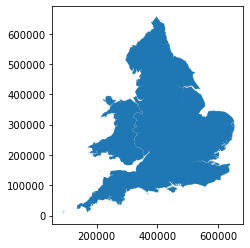

In [3]:
Countries_geo.plot()
Countries_geo.head(2)

### Read in Greater London's Built Up Area

In [4]:
# Read all Built Up Areas & filter them to Greater London
BUA = gpd.read_file('Data_Gen/package.gpkg', layer='BUA')
GLBUA = BUA[BUA['geography'].str.startswith('Greater London')]

,geography,geography code,Dwellings,Area_ha,Density_dha,geometry
4704,Greater London BUA,E34004707,4035768,173789.68,23.2,"MULTIPOLYGON (((494951.269 160099.919, 494951...."


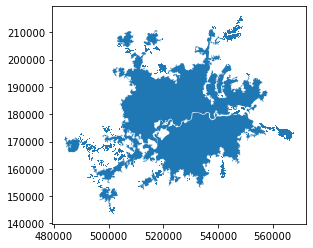

In [5]:
# Show
GLBUA.plot()
GLBUA.head(2)

### Read in Local Authorities, MSOAs, LSOAs, OAs

In [6]:
# Read the Local Authorities from the geopackage
LAD = gpd.read_file('Data_Gen/package.gpkg', layer='LAD')

,geography,geography code,Dwellings,Area_ha,Density_dha,geometry
0,City of London,E09000001,5513,290.39,19.0,"POLYGON ((532140.313 182191.902, 532134.913 18..."
1,Barking and Dagenham,E09000002,71079,3610.78,19.7,"MULTIPOLYGON (((548881.812 190803.003, 548886...."


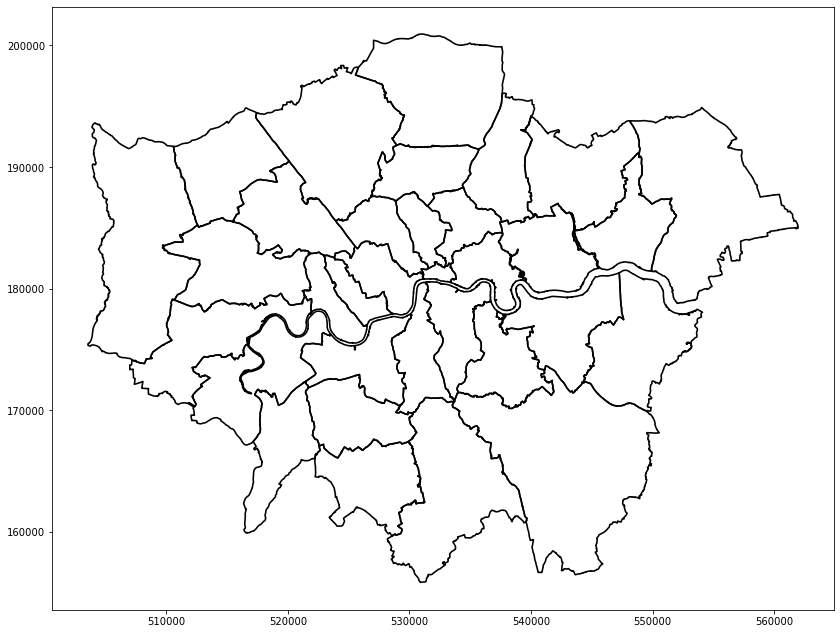

In [7]:
LAD.plot(figsize=(14,14), facecolor='none', edgecolor='black', linewidth=1.6, zorder=4, legend=True)
# show the new dataframe
LAD.head(2)

### Create Greater London boundary & dwelling density
Dwelling density data were downloaded for Greater London's Built Up Area and its Local Authorities but not for the the political boundary of Greater London. This step creates a dwelling density for Greater London's political boundary by dissolving together the geometries and number of dwellings of its constituent Local Authorities, calculating a dwelling density for the combined area.

In [8]:
# Create a temp column filled with 1s - this is a workaround to dissolve all rows together
LAD['temp']=1
# Dissolve the LADs together based on the new code, summing the number of dwellings and the areas
GL = LAD[['Dwellings', 'Area_ha', 'geometry', 'temp']].dissolve(by='temp', aggfunc='sum')
# Calculate a Greater London dwelling density
GL['Density_dha'] = (GL['Dwellings'] / GL['Area_ha']).round(1)
# Give the geography a name
GL['geography'] = 'Greater London (political)'
# Reorder the columns
GL = GL[['geography', 'Dwellings', 'Area_ha', 'Density_dha', 'geometry']]
# reset the index
GL.reset_index(drop=True, inplace=True)

,geography,Dwellings,Area_ha,Density_dha,geometry
0,Greater London (political),3358163,157350.81,21.3,"MULTIPOLYGON (((547226.215 181299.305, 547320...."


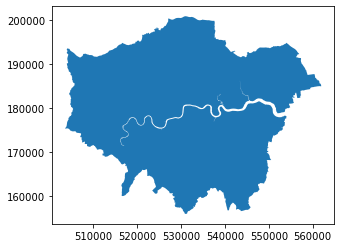

In [9]:
# Show
GL.plot()
GL.head(2)

## Buildings

In [10]:
# Read in the buildings
GLBUA_Buildings = gpd.read_file('Data_Gen/Buildings_GLBUA.gpkg', layer='Buildings_GLBUA')

### Overlay Buildings, Greater London and Greater London's Built Up Area (GLBUA)

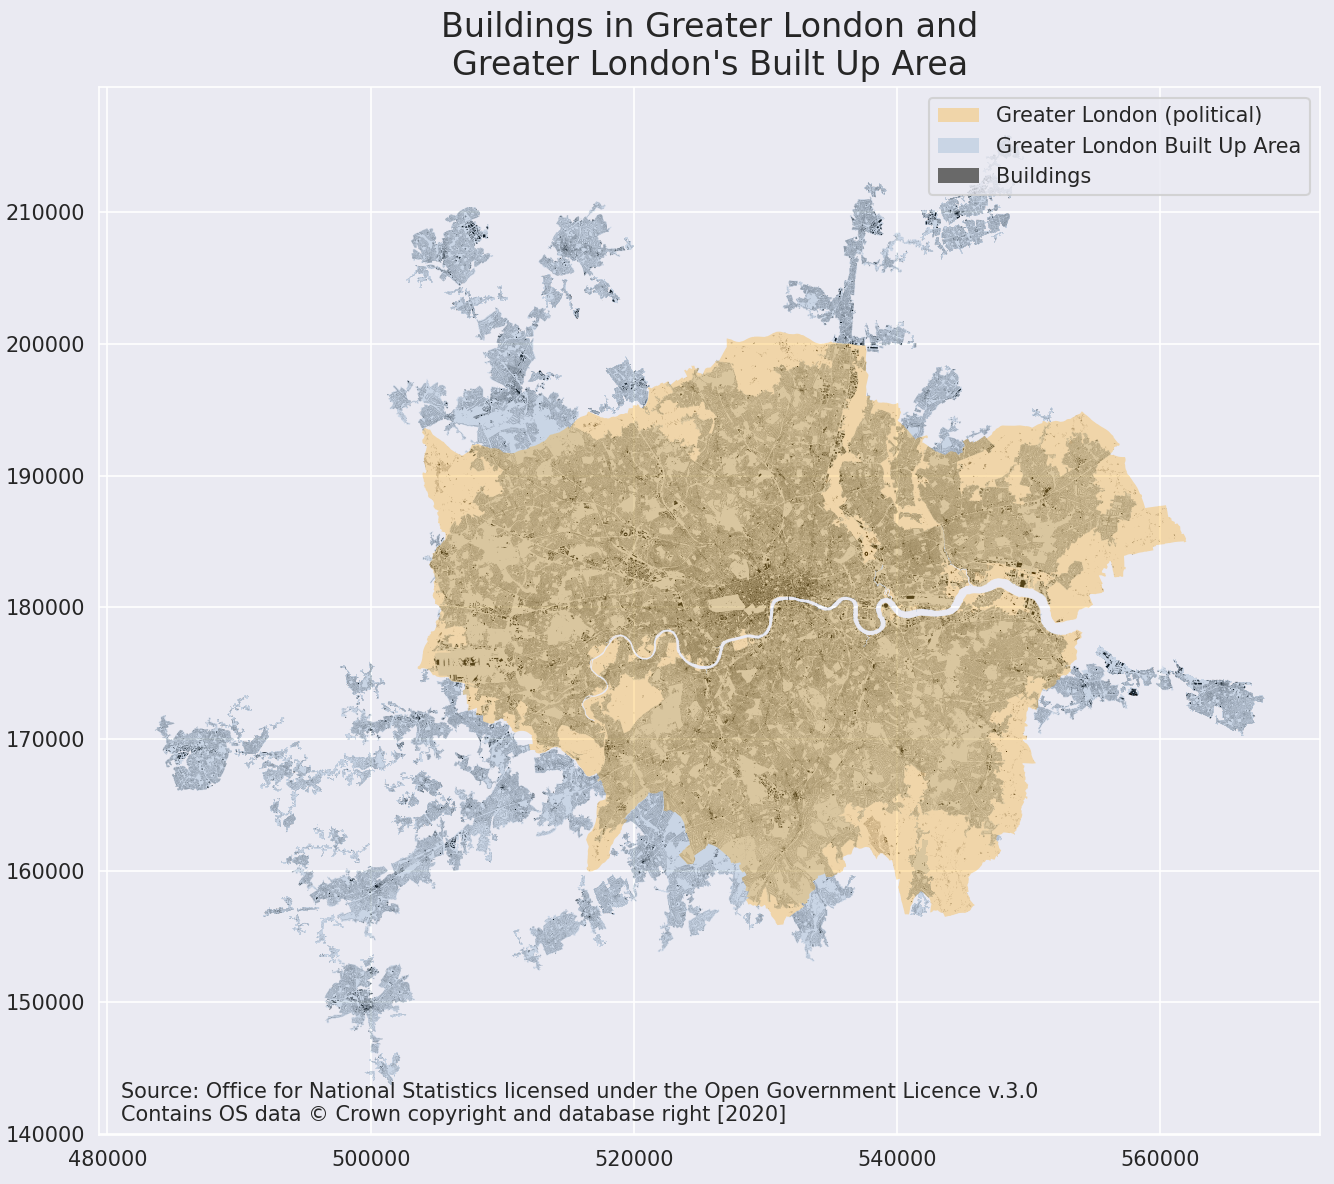

In [11]:
# Seaborn style
with sns.axes_style("darkgrid", {'figure.facecolor': '#EAEAF2'}):
    # Plot size and dpi
    fig, ax = plt.subplots(figsize=(9,8), dpi=150)
    # Greater London Built Up Area
    GLBUA.plot(ax=ax,
               facecolor='steelblue',
               edgecolor='none',
               zorder=2,
               alpha=0.2,
    )
    # Greater London (political)
    GL.plot(ax=ax,
            facecolor='orange',
            edgecolor='none',
            zorder=3,
            alpha=0.3,
    )
    # Buildings
    GLBUA_Buildings.plot(ax=ax,
                         facecolor='black',
                         edgecolor='none',
                         zorder=1,
    )
    # Title
    ax.set_title(label="Buildings in Greater London and\n"
                       "Greater London's Built Up Area",
                 fontdict={'fontsize':16,
                          })
    # Attribution
    ax.text(481000,141000,"Source: Office for National Statistics licensed under the Open Government Licence v.3.0\nContains OS data © Crown copyright and database right [2020]")
    # Legend
    legend_elements = [Patch(facecolor='orange',
                         edgecolor='none',
                         alpha=0.3,
                         label='Greater London (political)'),
                      Patch(facecolor='steelblue',
                             edgecolor='none',
                             alpha=0.2,
                             label='Greater London Built Up Area'),
                      Patch(facecolor='dimgrey',
                             edgecolor='none',
                             label='Buildings'),
                  ]
    ax.legend(handles=legend_elements, loc='upper right')
    # Save the file
    fig.tight_layout()
    fig.savefig('Buildings_GreaterLondon_GLBUA.png', facecolor='#EAEAF2')

### Read in the Greenbelt & filter to London Area only

In [12]:
greenbelt = gpd.read_file(Path('Data_In')/"Local_Authority_Greenbelt_boundaries_2011-12.shp")
# Project to British National Grid
greenbelt.to_crs("epsg:27700", inplace=True)
# Filter to London Area
London_area_greenbelt = greenbelt[greenbelt['GB_name'] == 'London Area Greenbelt']

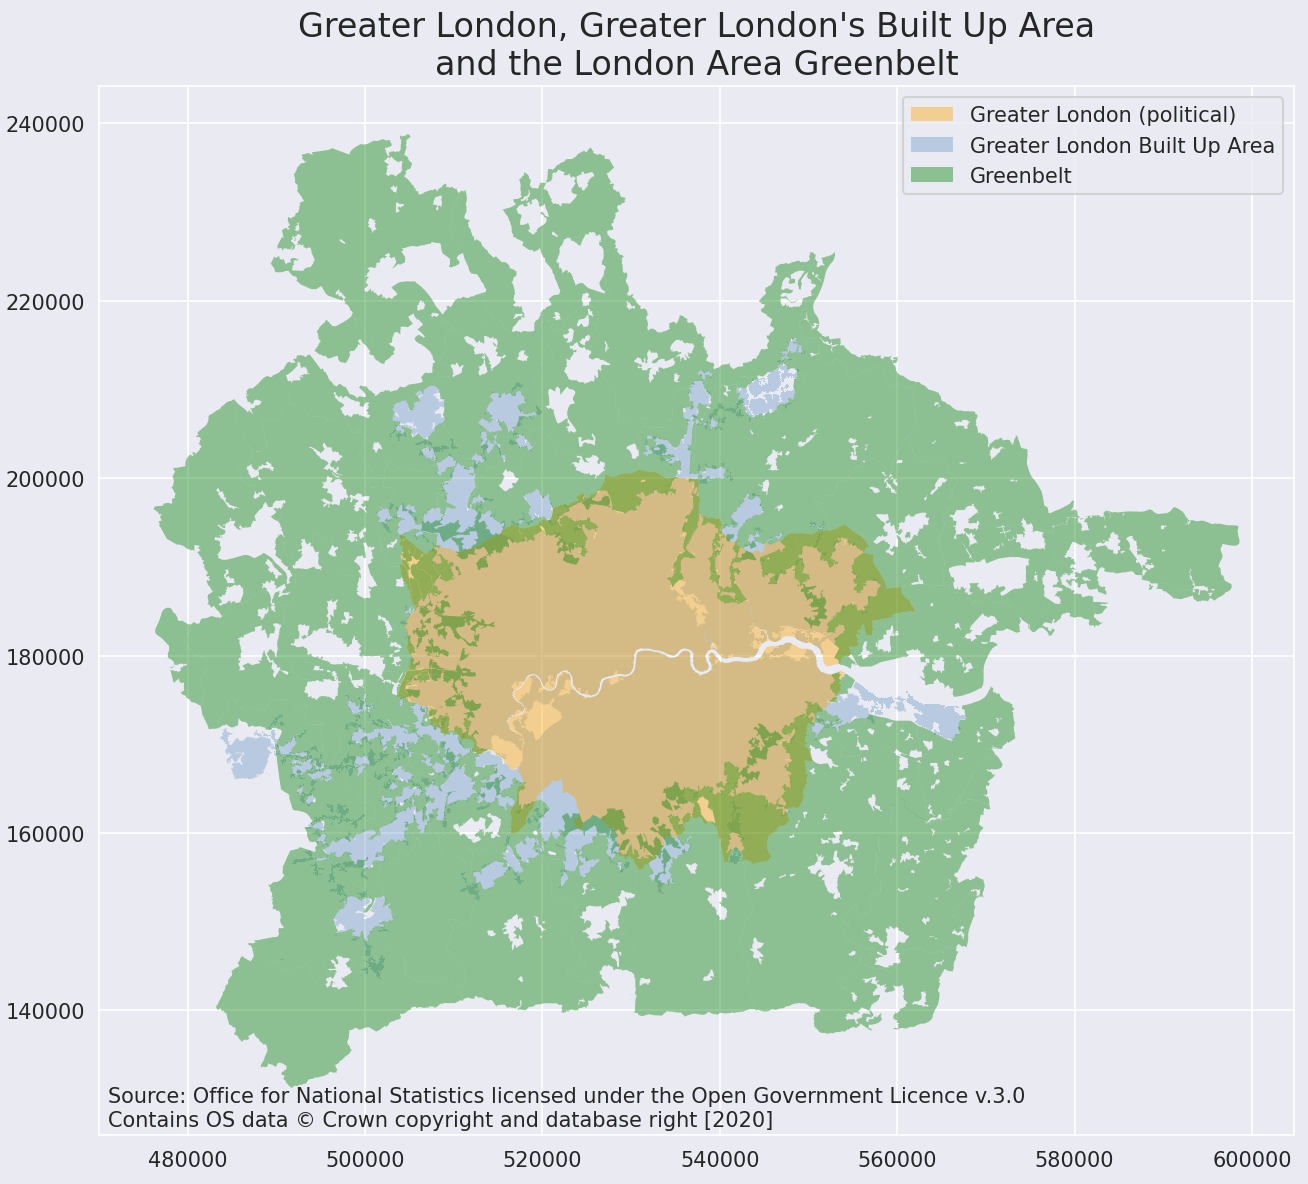

In [23]:
# Seaborn style
with sns.axes_style("darkgrid", {'figure.facecolor': '#EAEAF2'}):
    # Plot size and dpi
    fig, ax = plt.subplots(figsize=(9,8), dpi=150)
    # Greater London Built Up Area
    GLBUA.plot(ax=ax,
               facecolor='steelblue',
               edgecolor='none',
               zorder=2,
               alpha=0.3,
    )
    # Greater London (political)
    GL.plot(ax=ax,
            facecolor='orange',
            edgecolor='none',
            zorder=3,
            alpha=0.4,
    )
    # London Area Greenbelt
    London_area_greenbelt.plot(ax=ax,
                               facecolor='green',
                               edgecolor='none',
                               zorder=4,
                               alpha=0.4)
    # Title
    ax.set_title(label="Greater London, Greater London's Built Up Area\n"
                       "and the London Area Greenbelt",
                 fontdict={'fontsize':16,
                          })
    # Attribution
    ax.text(471000,127000,"Source: Office for National Statistics licensed under the Open Government Licence v.3.0\nContains OS data © Crown copyright and database right [2020]")
    # Legend
    legend_elements = [Patch(facecolor='orange',
                         edgecolor='none',
                         alpha=0.4,
                         label='Greater London (political)'),
                      Patch(facecolor='steelblue',
                             edgecolor='none',
                             alpha=0.3,
                             label='Greater London Built Up Area'),
                      Patch(facecolor='green',
                             edgecolor='none',
                             alpha=0.4,
                             label='Greenbelt'),
                  ]
    ax.legend(handles=legend_elements, loc='upper right')
    # Save the file
    fig.tight_layout()
    fig.savefig('GreaterLondon_GLBUA_Greenbelt.png', facecolor='#EAEAF2')

In [14]:
London_area_greenbelt.head(2)

,GB_name,LA_Name,ONS_Code,Area_Ha,Perim_Km,geometry
1,London Area Greenbelt,Bracknell Forest (B),E06000036,3840.763418,55.789652,"POLYGON ((485134.226 175127.407, 485145.826 17..."
3,London Area Greenbelt,Greenwich London Boro,E09000011,0.539995,0.502667,"POLYGON ((544310.509 172281.442, 544294.034 17..."


#### Calculate the relative area of the London Area Greenbelt and the Greater London Built Up Area

In [15]:
total_area_GLBUA = round(GLBUA.geometry.area.sum() / 10_000, 0)
total_area_London_Area_Greenbelt = round(London_area_greenbelt.geometry.area.sum() / 10_000, 0)

print("Greater London Built Up Area (hectares):", total_area_GLBUA)
print("London Area Greenbelt (hectares):", total_area_London_Area_Greenbelt)
print(round((total_area_London_Area_Greenbelt/total_area_GLBUA),2))

Greater London Built Up Area (hectares): 173790.0
London Area Greenbelt (hectares): 514571.0
2.96


#### Filter the London Area Greenbelt further to just those areas inside Greater London

In [16]:
GL_greenbelt = London_area_greenbelt[London_area_greenbelt['ONS_Code'].isin(LAD['geography code'])].copy()

rows, columns: (155, 6)


,GB_name,LA_Name,ONS_Code,Area_Ha,Perim_Km,geometry
3,London Area Greenbelt,Greenwich London Boro,E09000011,0.539995,0.502667,"POLYGON ((544310.509 172281.442, 544294.034 17..."
4,London Area Greenbelt,Kingston upon Thames London Boro,E09000021,639.206900,19.333490,"POLYGON ((518183.753 165717.257, 518179.603 16..."


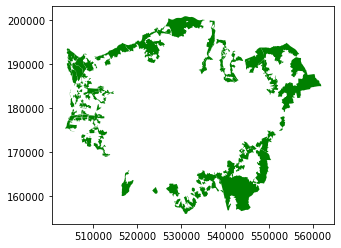

In [17]:
# Show
print("rows, columns:", GL_greenbelt.shape)
GL_greenbelt.plot(color='green')
GL_greenbelt.head(2)

In [18]:
# Show rows with invalid geometry
invalid_geometry_mask = ~GL_greenbelt['geometry'].is_valid
GL_greenbelt[invalid_geometry_mask]

,GB_name,LA_Name,ONS_Code,Area_Ha,Perim_Km,geometry
3,London Area Greenbelt,Greenwich London Boro,E09000011,0.539995,0.502667,"POLYGON ((544310.509 172281.442, 544294.034 17..."
94,London Area Greenbelt,Bromley London Boro,E09000006,685.098137,34.015005,"POLYGON ((544717.059 172249.543, 544721.239 17..."
96,London Area Greenbelt,Bromley London Boro,E09000006,5431.453951,79.981709,"POLYGON ((542928.641 165940.420, 542922.450 16..."
252,London Area Greenbelt,Harrow London Boro,E09000015,819.393700,21.000417,"POLYGON ((513396.426 192248.071, 513396.497 19..."
256,London Area Greenbelt,Harrow London Boro,E09000015,118.934438,5.304916,"POLYGON ((513799.009 190595.604, 513799.124 19..."
710,London Area Greenbelt,Havering London Boro,E09000016,1630.404661,35.428462,"POLYGON ((549674.508 192445.890, 549674.507 19..."
711,London Area Greenbelt,Havering London Boro,E09000016,4028.541281,65.031923,"POLYGON ((555155.746 190634.072, 555155.747 19..."
717,London Area Greenbelt,Bexley London Boro,E09000004,86.047244,6.946307,"POLYGON ((545796.182 171214.502, 545804.770 17..."
724,London Area Greenbelt,Waltham Forest London Boro,E09000031,284.591643,20.918838,"POLYGON ((539490.724 191046.594, 539490.814 19..."


In [19]:
# For the rows with invalid geometry apply a buffer of 0 to 'fix' them
GL_greenbelt.loc[invalid_geometry_mask,'geometry'] = GL_greenbelt.loc[invalid_geometry_mask,'geometry'].buffer(0)
# Show any remaining rows with invalid geometry
GL_greenbelt[~GL_greenbelt.is_valid]

,GB_name,LA_Name,ONS_Code,Area_Ha,Perim_Km,geometry


In [20]:
# Dissolve the geometries for each Local Authority together to get one geometry per Local Authority
LAD_greenbelt = GL_greenbelt.dissolve(by='ONS_Code', aggfunc='sum')
LAD_greenbelt

,geometry,Area_Ha,Perim_Km
ONS_Code,,,
E09000002,"MULTIPOLYGON (((549316.743 187549.319, 549325....",528.448160,32.673279
E09000003,"MULTIPOLYGON (((522659.780 191574.039, 522661....",2381.923208,81.434926
E09000004,"MULTIPOLYGON (((545796.182 171214.502, 545804....",1117.915615,47.200734
E09000006,"MULTIPOLYGON (((539876.119 165138.656, 539877....",7727.994081,144.581201
E09000008,"MULTIPOLYGON (((528653.369 158430.224, 528651....",2309.060345,109.209469
E09000009,"MULTIPOLYGON (((511758.621 180176.234, 511743....",333.342601,32.392665
E09000010,"MULTIPOLYGON (((536671.163 199954.259, 536748....",3070.996876,69.067102
E09000011,"POLYGON ((544310.509 172281.442, 544329.816 17...",0.539995,0.502667
E09000014,"MULTIPOLYGON (((534804.940 189068.402, 534801....",61.348131,9.125622


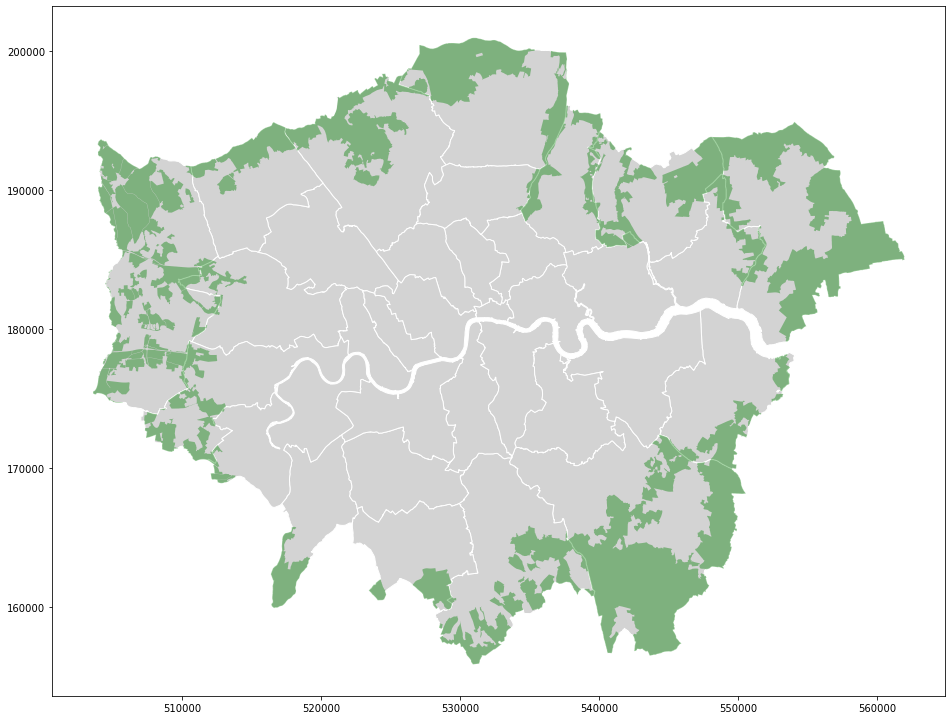

In [21]:
ax = LAD.plot(figsize=(16,16),
              edgecolor='white',
              facecolor='lightgrey')
LAD_greenbelt.plot(ax=ax,
                   color='green',
                   alpha=0.4)

In [22]:
total_area_LAD_greenbelt = round(LAD_greenbelt.geometry.area.sum() / 10_000, 0)
total_area_London_Area_Greenbelt = round(London_area_greenbelt.geometry.area.sum() / 10_000, 0)

print("LAD Greenbelt (hectares):", total_area_LAD_greenbelt)
print("London Area Greenbelt (hectares):", total_area_London_Area_Greenbelt)
print("London Area Greenbelt outside Greater London (political)", round((1 - (total_area_LAD_greenbelt/total_area_London_Area_Greenbelt)),2))

LAD Greenbelt (hectares): 35267.0
London Area Greenbelt (hectares): 514571.0
London Area Greenbelt outside Greater London (political) 0.93
